# Final Project

In [1]:
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

In [55]:
# Determines path to each class folder
dataset_path = 'dataset'

instrument_labels = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(instrument_labels)
print(len(instrument_labels))


['Piano', 'Banjo', 'Hi_Hats', 'Violin', 'Cymbals', 'Floor_Tom', 'Trombone', 'Clarinet', 'Organ', 'Accordion', 'Trumpet', 'Harmonica', 'Acoustic_Guitar', 'Saxophone', 'vibraphone', 'Mandolin', 'Tambourine', 'Harmonium', 'cowbell', 'Ukulele', 'Horn', 'Dobro', 'Shakers', 'Electro_Guitar', 'flute', 'Keyboard', 'Bass_Guitar', 'Drum_set']
28


In [25]:
instrument_map = {index: instrument_name for index , instrument_name in enumerate(instrument_labels)}
print(instrument_map)


{0: 'Piano', 1: 'Banjo', 2: 'Hi_Hats', 3: 'Violin', 4: 'Cymbals', 5: 'Floor_Tom', 6: 'Trombone', 7: 'Clarinet', 8: 'Organ', 9: 'Accordion', 10: 'Trumpet', 11: 'Harmonica', 12: 'Acoustic_Guitar', 13: 'Saxophone', 14: 'vibraphone', 15: 'Mandolin', 16: 'Tambourine', 17: 'Harmonium', 18: 'cowbell', 19: 'Ukulele', 20: 'Horn', 21: 'Dobro', 22: 'Shakers', 23: 'Electro_Guitar', 24: 'flute', 25: 'Keyboard', 26: 'Bass_Guitar', 27: 'Drum_set'}


#### Function to extract statistical MFCC features (for Random Forest)

In [26]:
def extract_statistical_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        delta_mean = np.mean(mfcc_delta, axis=1)
        delta_std = np.std(mfcc_delta, axis=1)
        delta2_mean = np.mean(mfcc_delta2, axis=1)
        delta2_std = np.std(mfcc_delta2, axis=1)
        features = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std])
        return features, y, sr, mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None, None

#### Function to extract fixed-size MFCC image for CNN

In [27]:
def get_mfcc_image(file_path, n_mfcc=13, max_len=216):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate the MFCC to have a fixed number of frames (max_len)
        mfcc_fixed = librosa.util.fix_length(mfcc, size=max_len, axis=1)
        return mfcc_fixed
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

## Load Dataset and Extract Features

In [28]:
dataset_path = 'dataset'

audio_files = glob.glob(os.path.join(dataset_path, '**', '*.wav'), recursive=True)
audio_files = audio_files[:500]
print("Number of audio files found:", len(audio_files))

Number of audio files found: 500


In [39]:
features_list = []
labels_list = []
waveforms = []   # For visualization
sample_rates = []  # For visualization
mfccs = []       # For visualization
file_names = []  # To store file paths

# For CNN images
cnn_images = []


#### Process each audio file

In [ ]:
for file_path in audio_files:
    i = 0
    while i < 50:
        # Extract statistical features for Random Forest
        features, y, sr, mfcc = extract_statistical_features(file_path, n_mfcc=13)
        if features is not None:
            features_list.append(features)
            waveforms.append(y)
            sample_rates.append(sr)
            mfccs.append(mfcc)
            file_names.append(file_path)
            
            # Parse the filename to extract the emotion code (3rd part of the filename)
            base_name = os.path.basename(file_path)
            parts = base_name.split('-')
            if len(parts) >= 3:
                emotion_code = parts[2]
                label = instrument_map.get(emotion_code, -1)  # default to -1 if not found
                labels_list.append(label)
            else:
                labels_list.append(-1)
            
            # Extract MFCC image for CNN classifier
            mfcc_img = get_mfcc_image(file_path, n_mfcc=13, max_len=216)
            mfcc_img = librosa.util.normalize(mfcc_img)
            if mfcc_img is not None:
                cnn_images.append(mfcc_img)
            i+=1

#### Convert lists to numpy arrays

In [48]:
features_array = np.array(features_list)
labels_array = np.array(labels_list)
cnn_images = np.array(cnn_images)

print("Features array shape (Random Forest):", features_array.shape)
print("Labels array shape:", labels_array.shape)
print("CNN images shape:", cnn_images.shape)  # Expected shape: (num_samples, 13, 216)

Features array shape (Random Forest): (25000, 78)
Labels array shape: (25000,)
CNN images shape: (25000, 13, 216)


## Visualize an Example Audio File and its MFCC Heatmap

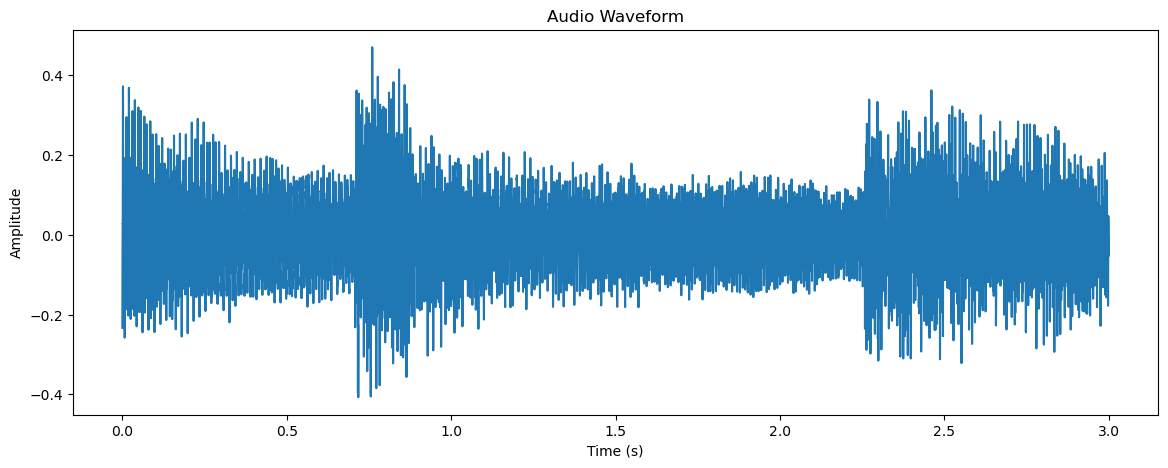

In [49]:
# CODE
t = np.linspace(0, len(y) / sr, num=len(y))
plt.figure(figsize=(14, 5))
plt.plot(t, y)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


#### Plot the MFCC heatmap using imshow (as an alternative to specshow)

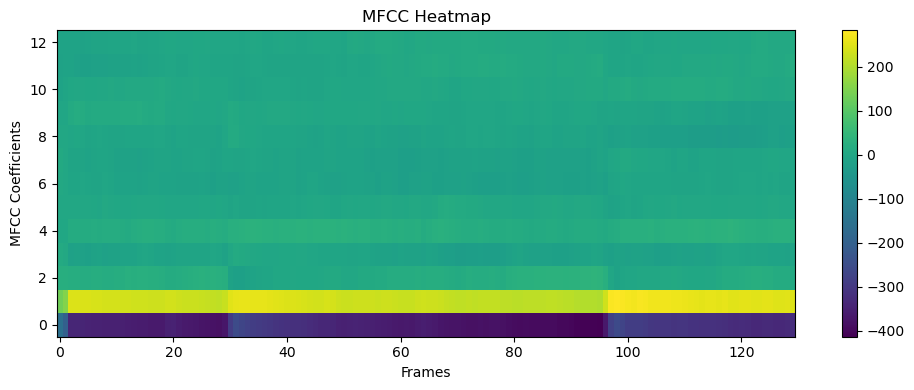

In [50]:
# CODE
plt.figure(figsize=(10, 4))
# Use imshow as an alternative to specshow
plt.imshow(mfcc, aspect='auto', origin='lower', interpolation='nearest')
plt.title("MFCC Heatmap")
plt.xlabel("Frames")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.tight_layout()
plt.show()

## Random Forest classifier

In [51]:
# CODE
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array)


In [52]:
# CODE
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Evaluate on the test set

In [53]:
# CODE
y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      5000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Random Forest Accuracy: 1.0


#### Plot the confusion matrix

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


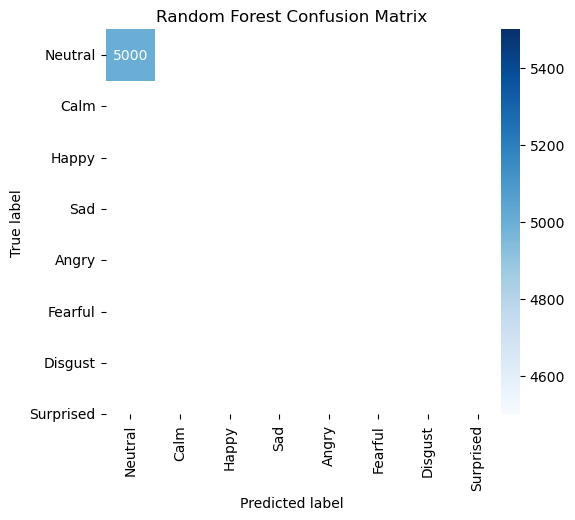

In [54]:
# CODE
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"], yticklabels=["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Random Forest Confusion Matrix")
plt.show()